# [Home](https://citizen-shield.github.io/multi-method-protective-behaviour/)

# Understanding personal protective behaviours and opportunities for interventions:
## Results from a multi-method investigation of cross-sectional data
#### Kaisa Sauro, James Twose, Gjalt-Jorn Peters, Matti Heino & Nelli Hankonen

#### [Literature review of models](https://docs.google.com/document/d/129KeoFputOHx6Bp5cfi9Omz6LN3p14qjNLD3TXnFEbI/edit?usp=sharing)

## approaches used here: _Linear Mixed Models (LMM)_

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import session_info

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GroupKFold, GroupShuffleSplit, RepeatedStratifiedKFold, RepeatedKFold

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats

In [3]:
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression

In [4]:
from sklearn.model_selection import KFold

In [5]:
import statsmodels.api as sm

In [7]:
import itertools

In [9]:
# from jmspack.frequentist_statistics import (correlation_analysis,
#                                             potential_for_change_index,
#                                             multiple_univariate_OLSs
#                                            )
# from jmspack.utils import (flatten,
#                            apply_scaling,
#                            JmsColors
#                           )

In [10]:
from pymer4 import Lmer

In [11]:
_ = sns.set_style("whitegrid")

### Virtual Environments and Packages

In [12]:
session_info.show(req_file_name="corona_preppers-requirements.txt",
      write_req_file=False) #add write_req_file=True to function to get requirements.txt file of packages used

### Read in data, show info and data head

In [13]:
df = pd.read_csv("data/shield_gjames_21-09-20_prepped.csv").drop("Unnamed: 0", axis=1)

In [14]:
df.head()

,id,sampling_weight,demographic_gender,demographic_age,demographic_4_areas,demographic_8_areas,demographic_higher_education,behaviour_indoors_nonhouseholders,behaviour_close_contact,behaviour_quarantined,...,intention_public_transport_recoded,intention_indoor_meeting_recoded,intention_restaurant_recoded,intention_pa_recoded,intention_composite,behaviour_indoors_nonhouseholders_recoded,behaviour_unmasked_recoded,behavior_composite,behavior_composite_recoded,intention_behavior_composite
0,1,2.060959,2,60+,2,7,0,2,5,2,...,0,0,0,0,0,1.000000,0.000000,0.000000,0.000000,0.000000
1,2,1.784139,2,40-49,1,1,1,3,3,2,...,0,1,1,1,3,0.785714,0.214286,0.168367,0.841837,1.920918
2,3,1.204000,1,60+,1,2,1,4,4,2,...,0,0,0,0,0,0.500000,0.214286,0.107143,0.535714,0.267857
3,4,2.232220,1,60+,2,6,0,4,3,2,...,0,2,0,2,4,0.500000,0.500000,0.250000,1.250000,2.625000
4,5,1.627940,2,18-29,1,3,0,6,3,2,...,0,2,0,0,2,0.000000,0.214286,0.000000,0.000000,1.000000


In [15]:
sdt_columns = df.filter(regex="sdt").columns.tolist()

In [16]:
drop_sdt = True
if drop_sdt:
    df=df.drop(sdt_columns, axis=1)

In [17]:
df.shape

(2272, 87)

### Specify the feature list, grouping variable, and specify the grouping variable as a categorical variable

In [18]:
target = "intention_behavior_composite"

In [19]:
df[target] = (df[target] - 10) * -1

In [20]:
features_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective").columns.tolist()

In [21]:
meta_columns = ['Original position', 'Variable name', 'Label',
       'Item english translation', 'Label short', 'Type', 'New variable name',
       'variable name helper',
       'Of primary interest as a predictor (i.e. feature)?', 'English lo-anchor',
       'English hi-anchor']

In [24]:
# meta_df = pd.read_excel("metadata/questionLabels.xlsx").loc[:, meta_columns]

In [25]:
meta_list = df.filter(regex="^automaticity|attitude|^norms|^risk|^effective|^behaviour|^intention").columns.tolist()

In [26]:
pd.set_option("display.max_colwidth", 350)
pd.set_option('display.expand_frame_repr', True)
# meta_df.loc[meta_df["New variable name"].isin(meta_list), ["Item english translation", "New variable name"]]

In [27]:
pd.set_option("display.max_colwidth", 100)

## EDA on the target
Check the amount of samples in the target

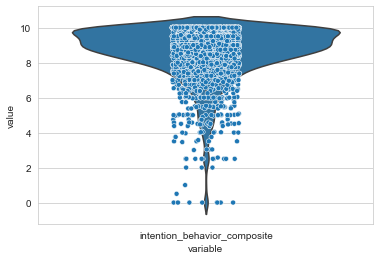

In [28]:
_ = sns.violinplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value"
               )
_ = sns.stripplot(data=df[[target]].melt(), 
                    x="variable", 
                    y="value",
                  edgecolor='white',
                  linewidth=0.5
               )

In [29]:
pd.crosstab(df["demographic_gender"], df["demographic_age"])

demographic_age,18-29,30-39,40-49,50-59,60+
demographic_gender,,,,,
1,114,169,187,168,337
2,281,185,229,211,391


In [30]:
target_df = df[target]
target_df.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
intention_behavior_composite,2272.0,8.582428,1.524704,-0.0,8.017857,8.964286,9.5,10.0


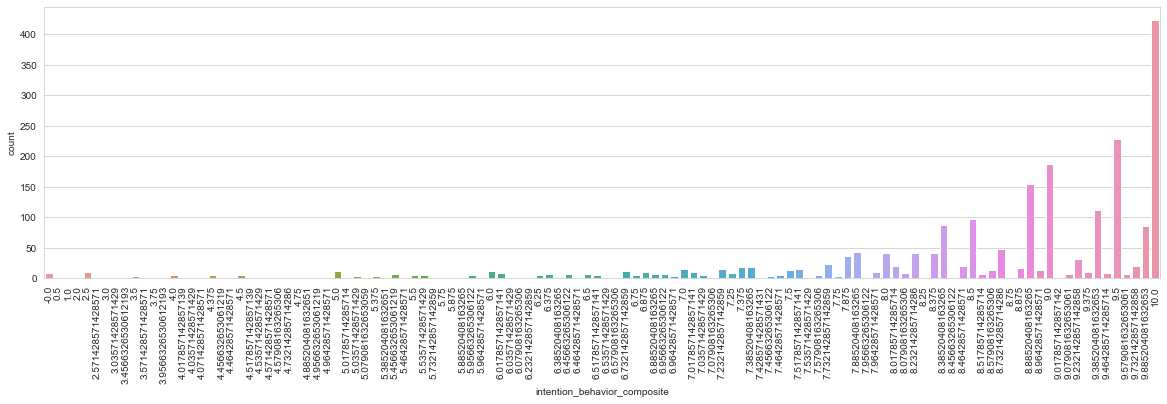

In [31]:
_ = plt.figure(figsize=(20, 5))
_ = sns.countplot(x=target_df)
_ = plt.xticks(rotation=90)

In [32]:
df = (df[["demographic_age", "demographic_higher_education"] + features_list + [target]])

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2272 entries, 0 to 2271
Data columns (total 30 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   demographic_age                   2272 non-null   object 
 1   demographic_higher_education      2272 non-null   int64  
 2   automaticity_carry_mask           2272 non-null   int64  
 3   automaticity_put_on_mask          2272 non-null   int64  
 4   inst_attitude_protects_self       2272 non-null   int64  
 5   inst_attitude_protects_others     2272 non-null   int64  
 6   inst_attitude_sense_of_community  2272 non-null   int64  
 7   inst_attitude_enough_oxygen       2272 non-null   int64  
 8   inst_attitude_no_needless_waste   2272 non-null   int64  
 9   norms_family_friends              2272 non-null   int64  
 10  norms_risk_groups                 2272 non-null   int64  
 11  norms_officials                   2272 non-null   int64  
 12  norms_

In [34]:
display(df[target].value_counts().head().to_frame()), df.shape[0], df[target].value_counts().head().sum()

,intention_behavior_composite
10.000000,424
9.500000,228
9.000000,187
8.885204,155
9.385204,112


(None, 2272, 1106)

## Multivariate Linear Regression

In [35]:
X = df[features_list]
y = df[target]

In [36]:
mod = sm.OLS(endog=y, exog=X)
res = mod.fit()
display(res.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     intention_behavior_composite   R-squared (uncentered):                   0.980
Model:                                      OLS   Adj. R-squared (uncentered):              0.980
Method:                           Least Squares   F-statistic:                              4050.
Date:                          Tue, 07 Dec 2021   Prob (F-statistic):                        0.00
Time:                                  22:26:48   Log-Likelihood:                         -3705.8
No. Observations:                          2272   AIC:                                      7466.
Df Residuals:                              2245   BIC:                                      7620.
Df Model:                                    27                                                  
Covariance Type:                      nonrobust                                                  
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
automaticity_carry_mask              0.0923      0.031      2.933      0.003       0.031       0.154
automaticity_put_on_mask             0.0787      0.034      2.331      0.020       0.012       0.145
inst_attitude_protects_self         -0.0120      0.024     -0.491      0.624      -0.060       0.036
inst_attitude_protects_others        0.2237      0.032      6.901      0.000       0.160       0.287
inst_attitude_sense_of_community    -0.0035      0.020     -0.173      0.863      -0.043       0.036
inst_attitude_enough_oxygen          0.1177      0.021      5.668      0.000       0.077       0.158
inst_attitude_no_needless_waste      0.0190      0.016      1.172      0.241      -0.013       0.051
norms_family_friends                 0.0758      0.027      2.840      0.005       0.023       0.128
norms_risk_groups                -4.061e-05      0.034     -0.001      0.999      -0.067       0.067
norms_officials                      0.1520      0.032      4.817      0.000       0.090       0.214
norms_people_present_indoors         0.1691      0.024      7.160      0.000       0.123       0.215
aff_attitude_comfortable             0.0224      0.029      0.778      0.437      -0.034       0.079
aff_attitude_calm                    0.0316      0.027      1.192      0.233      -0.020       0.084
aff_attitude_safe                    0.0213      0.031      0.688      0.492      -0.039       0.082
aff_attitude_responsible             0.0120      0.033      0.363      0.717      -0.053       0.077
aff_attitude_difficult_breathing     0.1773      0.019      9.375      0.000       0.140       0.214
effective_means_handwashing          0.0465      0.021      2.170      0.030       0.004       0.089
effective_means_masks                0.0202      0.028      0.721      0.471      -0.035       0.075
effective_means_distance             0.1063      0.026      4.127      0.000       0.056       0.157
effective_means_ventilation          0.0497      0.020      2.507      0.012       0.011       0.089
risk_likely_contagion                0.0551      0.023      2.344      0.019       0.009       0.101
risk_contagion_absent_protection     0.0012      0.020      0.062      0.951      -0.038       0.040
risk_severity                        0.1452      0.021      6.893      0.000       0.104       0.187
risk_fear_spread                     0.0224      0.026      0.848      0.396      -0.029       0.074
risk_fear_contagion_self            -0.0313      0.026     -1.206      0.228      -0.082       0.020
risk_fear_contagion_others          -0.0046   

In [73]:
top_feats = res.params.sort_values().tail(3).index.tolist()

In [77]:
ran_1 = df.filter(regex="demo").columns.tolist()[0]
ran_2 = df.filter(regex="demo").columns.tolist()[1]

In [78]:
formula_string = f"{target} ~ {' + '.join(top_feats)} + (1|{ran_1}) + (1|{ran_2})"
formula_string

'intention_behavior_composite ~ norms_people_present_indoors + aff_attitude_difficult_breathing + inst_attitude_protects_others + (1|demographic_age) + (1|demographic_higher_education)'

In [79]:
# Initialize model instance using 1 predictor with random intercepts and slopes
model = Lmer(formula_string, data=df)

# Fit it
model.fit(conf_int='profile', factors = {ran_1: df[ran_1].sort_values().unique().tolist()}, ordered=True)

boundary (singular) fit: see ?isSingular 

Formula: intention_behavior_composite~norms_people_present_indoors+aff_attitude_difficult_breathing+inst_attitude_protects_others+(1|demographic_age)+(1|demographic_higher_education)

Family: gaussian	 Inference: parametric

Number of observations: 2272	 Groups: {'demographic_age': 5.0, 'demographic_higher_education': 2.0}

Log-likelihood: -3686.406 	 AIC: 7372.812

Random effects:

                                     Name    Var    Std
demographic_age               (Intercept)  0.122  0.349
demographic_higher_education  (Intercept)  0.000  0.000
Residual                                   1.480  1.217

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),4.891,4.428,5.355,0.238,20.461,20.526,0.0,***
norms_people_present_indoors,0.279,0.241,0.317,0.019,2266.985,14.397,0.0,***
aff_attitude_difficult_breathing,-0.101,-0.134,-0.068,0.017,2265.041,-6.029,0.0,***
inst_attitude_protects_others,0.396,0.349,0.442,0.024,2264.352,16.824,0.0,***


In [ ]:
!jupyter nbconvert --to html LMM_clean.ipynb